In [493]:
import pandas as pd
import numpy as np


input_dir = "options_data/atm_iv_earnings_master.csv"
master = pd.read_csv(input_dir)

In [494]:
#pre-processing 
master["earning_date"] = pd.to_datetime(master['earning_date'])
master = master.sort_values("earning_date")


In [495]:
#calcualtion s

#winrate of trade - number of negatives / total
#average win
#average loss


master["percentage_change"] = master["price_change"] / master["price_pre"]
master["win/loss"] = np.where(master["price_change"] < 0, 1, 0) #win/loss column


In [496]:
win_rate = master["win/loss"].mean()
print(f"Win Rate: {win_rate}")

# Average win and loss percentage
average_win = abs(master.loc[master["price_change"] < 0, "percentage_change"].mean())
average_loss = abs(master.loc[master["price_change"] > 0, "percentage_change"].mean())
print(f"Average Win: {average_win}")
print(f"Average Loss: {average_loss}")

#mean percentage change for wins
#mean percentage change for losses 
win = win_rate * average_win 
loss = ((1 - win_rate) * average_loss)

net_expected = win - loss
net_expected

Win Rate: 0.6791569086651054
Average Win: 0.7351565795637567
Average Loss: 1.3658883318339667


np.float64(0.06105083515746135)

In [497]:
#kelly criterion
#pricechange / pricepre <- wins and losses, and get the average for each 

def kelly_criterion(win_rate, avg_win, avg_loss):
    """
    Calculate Kelly Criterion for position sizing
    
    Parameters:
    win_rate (float): Probability of winning (0 to 1)
    avg_win (float): Average win percentage (e.g., 0.05 for 5%)
    avg_loss (float): Average loss percentage (e.g., -0.02 for -2%)
    
    Returns:
    float: Kelly percentage (0 to 1)
    """
    # Win/loss ratio (use absolute value since loss is negative)
    win_loss_ratio = abs(avg_win / avg_loss)
    
    # Kelly formula
    kelly = win_rate - (1 - win_rate) / win_loss_ratio
    
    # Cap at reasonable levels (0% to 100%)
    return max(0, min(kelly, 1))


kelly_pct = kelly_criterion(win_rate, average_win, average_loss)
print(f"Full Kelly: {kelly_pct:.1%}")
print(f"Half Kelly (safer): {kelly_pct/2:.1%}")

Full Kelly: 8.3%
Half Kelly (safer): 4.2%


In [501]:
#start with 100k trading account
#allocate half kelly bank roll per trade
#run over 2023 - 2025
#graph pnl over lifetime
#calculate the stev of account value 

#factor in brokerage costs

starting_amount = 100000
criterion_perc = kelly_pct / 2 #half kelly

master = master[
    (master["earning_date"] >= "2024-01-01") &
    (master["earning_date"] <= "2026-01-01")
]

master = master[~master["symbol"].isin(["RTX", "BA", "PFE", "LMT", "MRK", "UNH", "ABBV", "LLY", "JNJ", "CAT"])]
backtest = master.copy().reset_index(drop=True)


backtest["percentage_won"] = -1*backtest["percentage_change"]
account_value = starting_amount
account_values = [account_value]

for i in range(len(backtest)):
    position_size = account_value * criterion_perc

    contract_n = (position_size / backtest.loc[i, "price_pre"]).round() #integer
    brokerage_cost = 0.01 * contract_n 
    

    # Calculate trade P&L (brokerage costs for entry + exit)
    trade_pnl = position_size * backtest.loc[i, "percentage_won"] - (brokerage_cost * 2)
    
    # Update account value
    account_value += trade_pnl
    account_values.append(account_value)

# Store final account values (remove first value to align with trades)
backtest["MONEY"] = account_values[1:]

In [499]:
backtest


,symbol,earning_date,option_type,expiry,strike,ticker,price_pre,price_post,price_change,iv_pre,iv_post,iv_crush,pre_file,post_file,percentage_change,win/loss,percentage_won,MONEY
0,PG,2024-01-23,put,2024-01-26,145.0,O:PG240126P00145000,1.00,0.03,-0.97,0.171663,0.011031,16.063204,2024-01-22,2024-01-24,-0.970000,1,0.970000,103861.586469
1,PG,2024-01-23,call,2024-01-26,145.0,O:PG240126C00145000,4.12,7.65,3.53,0.674101,1.783445,-110.934410,2024-01-22,2024-01-24,0.856796,0,-0.856796,100124.708478
2,GE,2024-01-23,call,2024-03-15,105.0,O:GE240315C00105000,28.00,23.90,-4.10,1.769501,1.528715,24.078618,2024-01-22,2024-01-24,-0.146429,1,0.146429,100727.552328
3,GOOGL,2024-01-30,call,2024-02-02,145.0,O:GOOGL240202C00145000,9.65,0.19,-9.46,1.589249,0.039566,154.968260,2024-01-29,2024-01-31,-0.980311,1,0.980311,104810.326851
4,GOOGL,2024-01-30,put,2024-02-02,145.0,O:GOOGL240202P00145000,1.06,5.00,3.94,0.181578,1.172840,-99.126161,2024-01-29,2024-01-31,3.716981,0,-3.716981,88469.898425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,GE,2025-10-21,call,2025-10-24,300.0,O:GE251024C00300000,9.48,2.30,-7.18,0.750469,0.254988,49.548144,2025-10-20,2025-10-22,-0.757384,1,0.757384,133104.627816
167,PYPL,2025-10-28,call,2025-10-31,70.0,O:PYPL251031C00070000,3.18,1.00,-2.18,1.082069,0.479191,60.287841,2025-10-27,2025-10-29,-0.685535,1,0.685535,136823.930616
168,UPS,2025-10-28,put,2025-10-31,75.0,O:UPS251031P00075000,0.10,0.01,-0.09,0.038136,0.008347,2.978935,2025-10-27,2025-10-29,-0.900000,1,0.900000,139664.574758
169,UPS,2025-10-28,put,2025-10-31,75.0,O:UPS251031P00075000,0.10,0.01,-0.09,0.038136,0.008347,2.978935,2025-10-27,2025-10-29,-0.900000,1,0.900000,142564.174060


Maximum Drawdown: -34.80%
Quarterly Sharpe: 0.44
Annualized Sharpe: 0.88


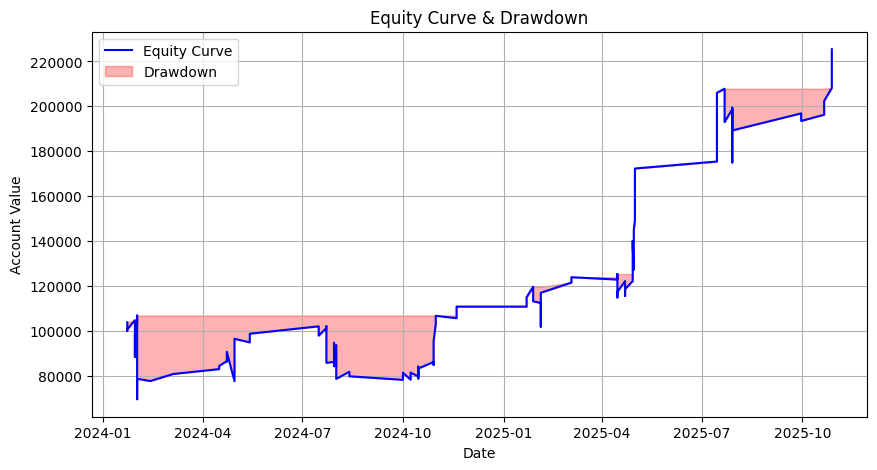

In [502]:
import matplotlib.pyplot as plt


account_values = backtest["MONEY"]  

#Compute returns
returns = account_values.pct_change().fillna(0)

#Maximum Drawdown (MDD)
running_max = account_values.cummax()
drawdown = (account_values - running_max) / running_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

earning_dates = pd.to_datetime(backtest["earning_date"])
# Assign each trade to a quarter, compute per-quarter returns, and subtract quarterly rfr
backtest["quarter"] = earning_dates.dt.to_period("Q")
quarterly_returns = backtest.groupby("quarter")["MONEY"].agg(['first', 'last'])
quarterly_returns['return'] = (quarterly_returns['last'] - quarterly_returns['first']) / quarterly_returns['first']
rfr_quarter = 0.045 / 4
quarterly_returns['excess_return'] = quarterly_returns['return'] - rfr_quarter

#Sharpe ratio per quarter
sharpe_per_quarter = quarterly_returns['excess_return'].mean() / quarterly_returns['excess_return'].std()

#Annualize Sharpe (4 quarters/year)
sharpe_annualized = sharpe_per_quarter * np.sqrt(4)

print(f"Quarterly Sharpe: {sharpe_per_quarter:.2f}")
print(f"Annualized Sharpe: {sharpe_annualized:.2f}")


plt.figure(figsize=(10,5))
plt.plot(backtest["earning_date"], account_values, label='Equity Curve', color='blue')
plt.fill_between(backtest["earning_date"], account_values, account_values.cummax(), 
                 color='red', alpha=0.3, label='Drawdown')
plt.title('Equity Curve & Drawdown')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.legend()
plt.grid(True)
plt.show()